# Natural Language Processing<br> Sentiment Analysis Classification

### Thomas Webb<br>March 30th, 2021

Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). This data will be used for a sentiment analysis job about the problems of each major U.S airline.

Link to the Kaggle dataset: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

# Import Libraries and Data

In [1]:
import re
import string
import unicodedata
import contractions

# data structures and organization
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

# visualizations
import seaborn as sns
sns.set(rc={'figure.figsize':(15,5)})
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, roc_auc_score
from yellowbrick.classifier import ClassificationReport, ROCAUC

# NLP text pre-processing and vectorization
import nltk
from bs4 import BeautifulSoup
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# clasification model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

/Users/thomaswebb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('Tweets.csv')

In [3]:
df.shape

(14640, 15)

In [4]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Exploratory Data Analysis

In [5]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

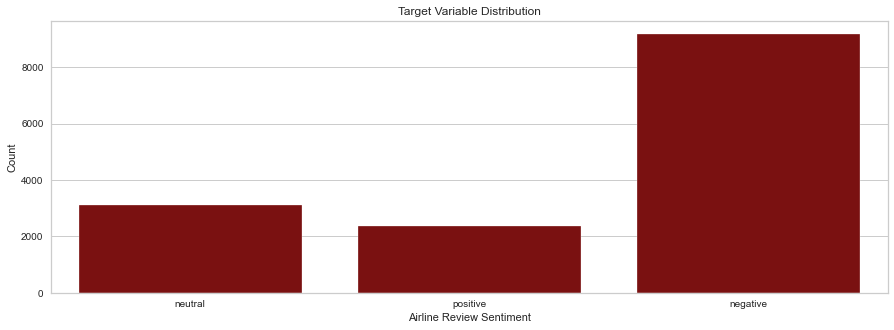

In [6]:
# visualize target variable distribution
plt.figure(figsize=(15,5))
sns.countplot(df['airline_sentiment'], color='darkred')
plt.title('Target Variable Distribution')
plt.xlabel('Airline Review Sentiment')
plt.ylabel('Count')
plt.show()

##### `Insights:`
- A large majority of the tweets collected in the study contained words that carry a **negative** sentiment against a major airline. This may suggest a serious issue with poor service by the airlines, or more likely, this is because people are more likely to speak out about negative experiences, and say nothing about **neutral** or **positive** experiences.
- In datasets with a largely skewed target variable, accuracy can be a misleading performance metric, so it will be important to review metrics such as **precision** and **recall** in this study.

In [7]:
full_confident_df = df[df['airline_sentiment_confidence'] == 1.0]
reasonably_confident_df = df[df['airline_sentiment_confidence'] >= 0.7]
print("Total Entries:", df.shape[0])
print("Entries with 1.0 Confidence:", full_confident_df.shape[0], "(", round((full_confident_df.shape[0]/df.shape[0]),2), "%)")
print("Entries with over 0.7 Confidence:", reasonably_confident_df.shape[0], "(", round((reasonably_confident_df.shape[0]/df.shape[0]),2), "%)")

Total Entries: 14640
Entries with 1.0 Confidence: 10445 ( 0.71 %)
Entries with over 0.7 Confidence: 10768 ( 0.74 %)


##### `Insights:`
- Over 70 percent of entries have a value of 'airline_sentiment_confidence' that is 1.0, meaning that the sentiment analysis can be considered reliable.

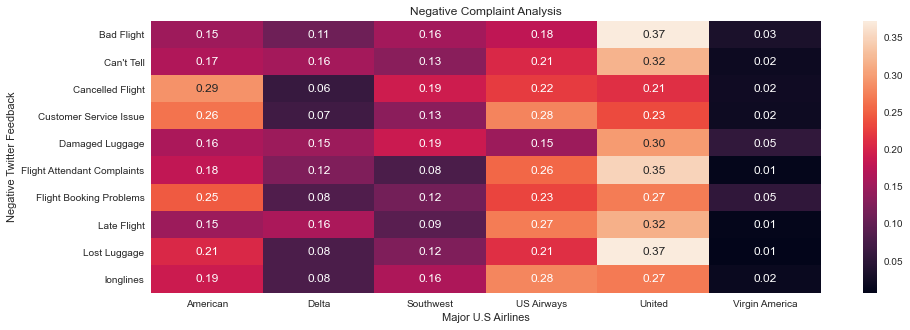

In [8]:
# compare some of the commonly recorded complaints with the airlines the feedback was intended for.
# this will show the airline's competitive performance in customer satisfaction.
plt.figure(figsize=(15,5))
sns.heatmap((pd.crosstab(df['negativereason'],df['airline'],normalize ='index')),
            annot = True,
            fmt = '.2f')
plt.title('Negative Complaint Analysis')
plt.xlabel('Major U.S Airlines')
plt.ylabel('Negative Twitter Feedback')
plt.show()

##### `Insights:`
- Use this above heatmap as a quick visualization to compare shortcomings of the major U.S airlines in customer satisfaction. At a glance you can see how each airline compares to the others in areas of common customer twitter complaints.
<br><br>**Key Takeaways:**<br><br>
- **American Airlines** sees a lot of complaints in the areas of **Cancelled Flights** and **Flight Booking problems**. It is recommended that **American Airlines** investigate their booking process. Have they been frequently over-booking flights? If so, why? Are there any routes that are frequently overbooked? Could additional flights be added to those routes? What is being done to compensate customers whos flights get cancelled?<br><br>
- **Delta Airlines** complaints are mostly about **Late Flights** and **Damaged Luggage**. It is recommended that **Delta Airlines** investigate the reasons for late flights. Are there scheduling conflicts that can be avoided, or are flights delayed by weather or other uncontrollable reasons? When a flight is significantly late, are any corrective customer satisfaction actions taken?<br><br>
- **Southwest Airlines** has remarkably low Flight Attendant Complaints, and most complaints are regarding **damaged luggage** or **cancelled flights**. It is reccomended that **Southwest Airlines** challenges their baggage handling teams to make luggage condition a priority, and maintain efficiency while elevating the level of care used on luggage. It is also reccomended to revisit instances where flights have been cancelled. Where those flights overbooked? If so, why? How did the airline make that situation right? Did the passengers get compensated for accomodations regarding their cancelled flight? Maybe they could get upgraded to first class on their next available flight for free?<br><br>
- **US Airways** has remarkably low damaged luggage complaints, and most complaints are regarding **long lines**, **customer service**, and **flight attendant complaints**. This is bad news initially because the customers are currently dissatisfied, but ultimately good news, because these are factors where the airline has relatively more control. It is recommended the **US Airways** check in with middle management to make sure that employees have everything they need in order to facilitate an efficient travel process that leaves customers satisfied. After this is done, it is recommended that the airline create in-service trainings where flight attendants and airport staff can focus on elevating their customer service skills. Maybe the airline could create a cash bonus incentive system for employees would recieve positive customer feedback?<br><br>
- **United Airlines** has recieved a disporportionate amount of complaints about **lost luggage**. It is recommended that **United Airlines** investigate the reason behind lost luggage cases. Was the luggage eventually foun, and if so, where was it found? How is luggage cataloged during flight transfers? What checklists are in place to make sure all bags are where they belong before planes move? When a customer's luggage is lost, what actions are taken to compensate the customer? Does the airline offer a "luggage insurance" for those who are weary of the issue?<br><br>
- **Virgin Airlines** appears to have much fewer complaints than the other airlines, however, they have a much smaller volume of total mentions, (including positive and neutral). That being said, **Virgin Airlines** biggest complaint is **damaged luggaged**, it is reccomended that **Virgin Airlines** work on the luggage handling and transfer process. Employees handling bagged should be trained to know that the condition of the bags is currently the customers biggest concern.

In [9]:
# Compare total number of positive and negative sentiments from each airline
sent_df = pd.crosstab(df['airline'],df['airline_sentiment'],normalize ='index')
sent_df.sort_values(by=['positive'], ascending = False)

airline_sentiment,negative,neutral,positive
airline,,,
Virgin America,0.359127,0.339286,0.301587
Delta,0.429793,0.325383,0.244824
Southwest,0.490083,0.274380,0.235537
United,0.688906,0.182365,0.128728
American,0.710402,0.167814,0.121783
US Airways,0.776862,0.130793,0.092345


##### `Insights:`
- The dataframe above offers a competitive analysis of the reviews of the major U.S airlines represented in the twitter study. Pay close attention to the normalized "positive" column. This percent of satisfied customer reviews is a valuable metric for determining customer satisfaction.
- **Virgin America** has the best performance in terms of customer satisfaction, with over **30%** of twitter mentions having a **positive** sentiment, and only **36%** having **negative** sentiment.
- **US Airways** has the worst performance in terms of customer satisfaction, with less than **10%** of twitter mentions having a positive sentiment, and over **77%** having **negative** sentiment.

In [10]:
# review the most dissatisfied customers
name_df = pd.crosstab(df['name'],df['airline_sentiment'])
name_df.sort_values(by=['negative'], ascending = False).head(10)

airline_sentiment,negative,neutral,positive
name,,,
otisday,28,0,0
_mhertz,27,2,0
throthra,24,2,1
rossj987,23,0,0
weezerandburnie,23,0,0
ElmiraBudMan,18,1,0
GREATNESSEOA,18,2,2
scoobydoo9749,18,3,0
ThatJasonEaton,18,0,0


##### `Insights:`
- These are the customers who have registered the most complaints and negative sentiments over twitter in February 2015. A customer likely has to be wronged significantly in order to make 28 negative public posts in regards to a business, therefore these people should be considered "high priority" for corrective action in customer service.

# Prepare Data for Pre-Processing

In [11]:
# create a copy dataframe to work with that only includes relevant information
text_df = df[['text','airline_sentiment']].copy()

In [12]:
text_df.shape

(14640, 2)

In [13]:
text_df.head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


##### `Insights:`
- While the information in the original DataFrame may be valuable in a business intelligence capacity, that information is not necessarily relevant to our NLP predictive model. Removing all of the unnecessary information will make our model more successful.

# Text Pre-Processing

In [14]:
# initialize function to remove html tags (if there are any)
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text()
    return clean_text

text_df['text'] = text_df['text'].apply(lambda x : remove_html_tags(x))

##### `Insights:` 
- While there doesn't appear to be any html tags in the corpus of text data, it is good practice to remove any tags that may be hidden or embedded in data we haven't looked at, considering there are a large number of entries.

In [15]:
# initialize function to remove contractions
def replace_contractions(text):
    return contractions.fix(text)

text_df['text'] = text_df['text'].apply(lambda x : replace_contractions(x))

##### `Insights:`
- This is an important step in the process for words like **"you've"** or **"don't"**. Using this function to remove contractions turns **"you've"** into **"you have"** and **"don't"** into **"do not"**. While at first this may seem trivial, this will become important during tokenization.
- The effect of tokenization on a contraction creates 3 word tokens that lose their meaning, for example, **"you've"** will turn into **["you","'","ve"]** and **"don't"** will turn into **["don","'","t"]**, and this is not optimal for our model.

In [16]:
# initialize function to remove any numbers
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

text_df['text'] = text_df['text'].apply(lambda x : remove_numbers(x))

##### `Insights:`
- While numbers may offer significant information to a claim, they do not have any context that carries any significance when determining text sentiment. A "5" cannot really be positive or negative, therefore we will remove them.

In [17]:
# tokenization
text_df['text'] = text_df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
text_df.head(5)

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]",neutral
3,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]",negative
4,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]",negative


##### `Insights:`
- Each text entry has now been converted into a comma separated list of 'tokens' or words that can more easily be processed and cleaned up.
- The next part of NLP text pre-processing must take place after tokenization, because we will be cleaning up the individual words in order to prepare for building a predictive model.

In [18]:
# initialize functions to remove special characters and punctuations
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special_characters(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

##### `Insights:`
- Here we are using RegEx to define the function that removes punctuation, but we are using unicodedata to isolate non-ascii characters to remove from the text. Neither of these carry much significance on understanding text sentiment, therefore removing them will make our model perform better.

In [19]:
# initialize function to convert to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

##### `Insights:`
- By converting all letters to lowercase we are ensuring that all similar words are classified as the same. For example, **"McDonalds"**, **"Mcdonalds"**, and **"mcdonalds"** will be classified as 3 different words unless they are all converted to lowercase.

In [20]:
# initialize lemmatization function
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

##### `Insights:`
- Lemmatization is the process of returning all versions of an inflected word back to its original root or lemma.
- Lemmatization is more computationally expensive than stemming, but seeing as tweets are short in nature and there are only 14640 in the corpus, this won't be a problem.

In [21]:
# this function will apply all of the word pre-processing functions,
# then, it will join all of the tokens back together into sentences instead of a list.
def word_preprocessing(words):
    words = remove_special_characters(words)
    words = remove_punctuation(words)
    words = to_lowercase(words)
    words = lemmatize_list(words)
    return ' '.join(words)

text_df['text'] = text_df.apply(lambda row: word_preprocessing(row['text']), axis=1)
text_df.head()

,text,airline_sentiment
0,virginamerica what dhepburn say,neutral
1,virginamerica plus you have add commercials to the experience tacky,positive
2,virginamerica i do not today must mean i need to take another trip,neutral
3,virginamerica it be really aggressive to blast obnoxious entertainment in your guests face they have little recourse,negative
4,virginamerica and it be a really big bad thing about it,negative


##### `Insights:`
- You can see the text column has arrived back in sentence form, and in addition to being entirely lowercase, the special characters, punctuation, and unnecessary prefixes and suffixes have been removed.

# Vectorization
Creating a greater dimensionality that will help model performance by converting text data into numbers.

In [22]:
# CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000)
count_features = count_vectorizer.fit_transform(text_df['text'])
count_features = count_features.toarray()

count_features.shape

(14640, 1000)

In [23]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(text_df['text'])
tfidf_features = tfidf_features.toarray()

tfidf_features.shape

(14640, 1000)

##### `Insights:`
- Now by looking at the shapes of our DataFrames, you can see that the text column has been vectorized and broken out into 1000 different features. This will give much more valuable data to our classification model, and it will have better performance at classifying into our target variables classes.
- We will build the model and fit both versions of the vectorizes data on our model, in order to compare the performance of both methods.

# Fit and Evaluate

## *CountVectorizer Method Data*

In [24]:
# define variables and split the data into a training and testing set
labels = text_df['airline_sentiment']
x_train, x_test, y_train, y_test = train_test_split(count_features, labels, test_size=0.3, random_state=1)

In [25]:
# fit the model to our training data (using RandomForest classifier)
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state = 1)
model = model.fit(x_train, y_train)

print(model)
print("Cross Validation Accuracy:",np.mean(cross_val_score(model, count_features, labels, cv=10)))

RandomForestClassifier(n_jobs=-1, random_state=1)
Cross Validation Accuracy: 0.7381830601092896


In [26]:
# use the model to make classification predictions on the testing data
results = model.predict(x_test)

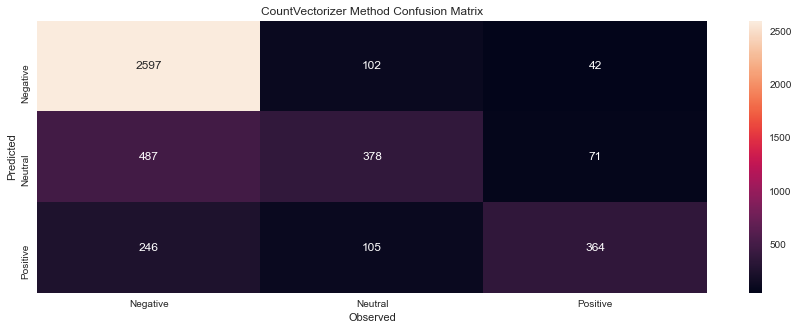

In [27]:
# evaluate the models performance in classification predictions on the testing data
count_cm = confusion_matrix(y_test, results)

count_matrix = pd.DataFrame(count_cm, index = [i for i in ['Negative','Neutral','Positive']],
                            columns = [i for i in ['Negative','Neutral','Positive']])

plt.figure(figsize=(15,5))
sns.heatmap(count_matrix, annot=True, fmt='g')
plt.title('CountVectorizer Method Confusion Matrix')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

##### `Insights:`
- From the above confusion matrix we see excellent performance by the model in correctly identifying negative sentiment.
- The model performed poorly at predicting neutral sentiments. In the confusion matrix row labelled for **neutral** predictions, you can see that the model incorrectly predicted neutrality for way more **positive** and **negative** sentiments than true observed **neutral** sentiments.

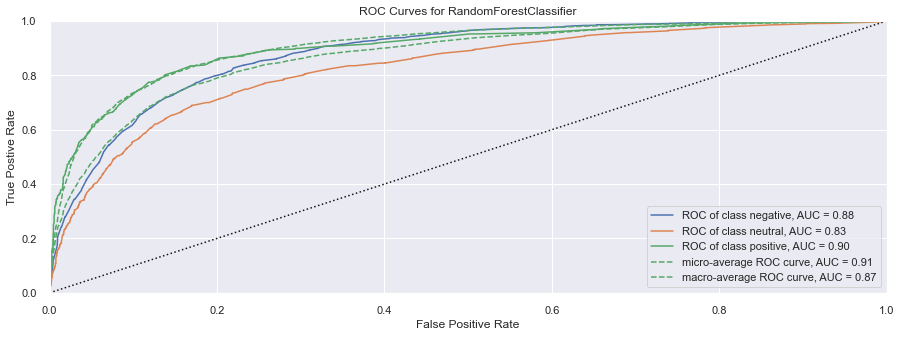

In [28]:
sns.set(rc={'figure.figsize':(15,5)})
roc = ROCAUC(RandomForestClassifier(n_estimators = 100))
roc.fit(x_train, y_train)
roc.score(x_test, y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic')
plt.legend(loc = "lower right")
roc.show()

## *TFIDF Method Data*

In [29]:
labels = text_df['airline_sentiment']
x_train, x_test, y_train, y_test = train_test_split(tfidf_features, labels, test_size=0.3, random_state=1)

In [30]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state = 1)
model = model.fit(x_train, y_train)

print(model)
print("Cross Validation Accuracy:",np.mean(cross_val_score(model, tfidf_features, labels, cv=10)))

RandomForestClassifier(n_jobs=-1, random_state=1)
Cross Validation Accuracy: 0.7314890710382513


In [31]:
results = model.predict(x_test)

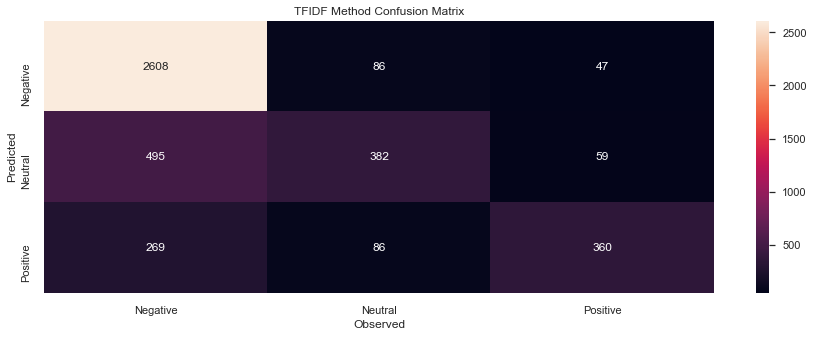

In [32]:
tfidf_cm = confusion_matrix(y_test, results)

tfidf_matrix = pd.DataFrame(tfidf_cm, index = [i for i in ['Negative','Neutral','Positive']],
                            columns = [i for i in ['Negative','Neutral','Positive']])

plt.figure(figsize=(15,5))
sns.heatmap(tfidf_matrix, annot=True, fmt='g')
plt.title('TFIDF Method Confusion Matrix')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

##### `Insights:`
- From the above confusion matrix we see excellent performance by the model in correctly identifying negative sentiment.
- The model performed poorly at predicting neutral sentiments. In the confusion matrix row labelled for **neutral** predictions, you can see that the model incorrectly predicted neutrality for way more **positive** and **negative** sentiments than true observed **neutral** sentiments.

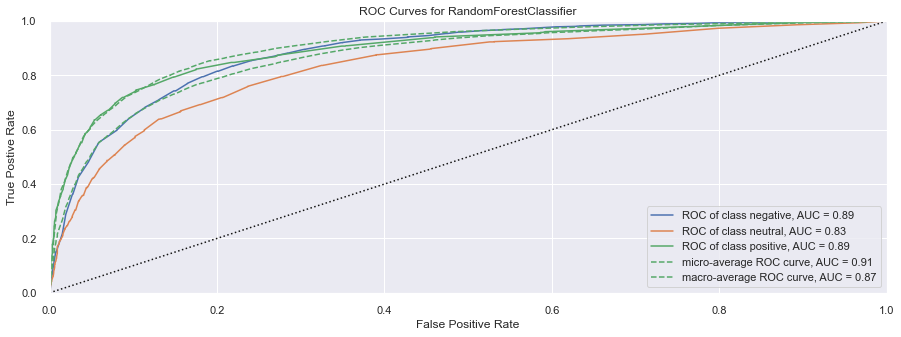

In [33]:
sns.set(rc={'figure.figsize':(15,5)})
roc = ROCAUC(RandomForestClassifier(n_estimators = 50))
roc.fit(x_train, y_train)
roc.score(x_test, y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic')
plt.legend(loc = "lower right")
roc.show()

# Summarize Results and Compare Performance

Although we approached text vectorization with two separate methods and fit each version of our text data separately, the results to both models are extraordinarily similar. Similar enough in fact to confidently determine that the vectorization methods don't have much influence on the performance of the Random Forest Classifier model we are building, at least at this scale. It is possible that the differences between the methods could become exagerrated at a much larger scale, or with a different classifier model.

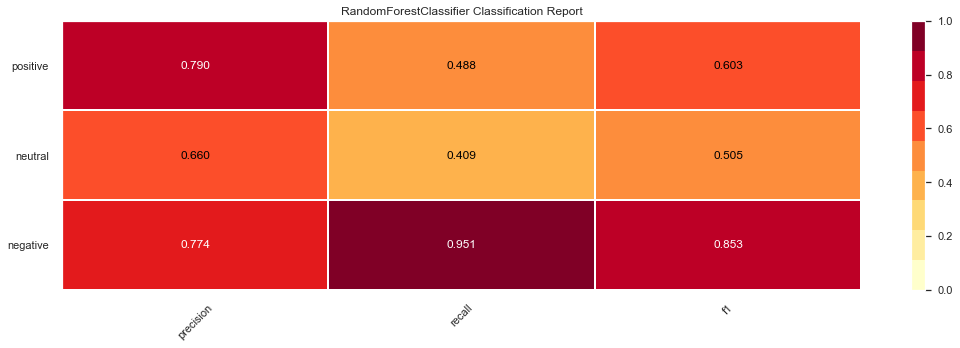

In [35]:
sns.set(rc={'figure.figsize':(15,5)})
model = RandomForestClassifier(n_estimators = 50)
cr = ClassificationReport(model)

cr.fit(x_train, y_train)       
cr.score(x_test, y_test)
cr.show() 

##### `Insights:`
- By comparing **precision**, **recall**, and **f1 score**, we can see that across the board our model is much better at predicting **negative** text sentiment than **neutral** or **positive** sentiments.
- Even though this model performs poorly with **neutral** or **positive** sentiments, the large majority of our dataset is made of **negative** sentiments, therefore our overall accuracy metrics are relatively high, which can be misleading.

### Potential Improvements

- The data for this study was scraped from twitter during only the month of February 2015. A more informative study would include text data from a wider range of time and situations (i.e travel surges during summer vacations and winter holidays).<br><br>
- There is a lot more data available regarding negative sentiments in the data. The addition of a "positive reason" column may add helpful insights, and seeing as our model is much betterat making negative sentiment predictions than the others, it may be a good idea to have more depth to the data surrounding positive and neutral text.